In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Projects/learning/lecture-notebooks/Lecture 7`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ ~/Projects/learning/lecture-notebooks/Lecture 7/Manifest.toml:0


In [2]:
Pkg.add("LinearAlgebra")
Pkg.add("PyPlot")
using LinearAlgebra
using PyPlot

   Resolving package versions...
┌ Warning: The active manifest file at `/home/xinyu/Projects/learning/lecture-notebooks/Lecture 7/Manifest.toml` has an old format that is being maintained.
│ To update to the new format, which is supported by Julia versions ≥ 1.6.2, run `import Pkg; Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
│ To then record the julia version re-resolve with `Pkg.resolve()` and if there are resolve conflicts consider `Pkg.update()`.
└ @ Pkg.Types ~/.julia/juliaup/julia-1.10.0+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/manifest.jl:318
  No Changes to `~/Projects/learning/lecture-notebooks/Lecture 7/Project.toml`
  No Changes to `~/Projects/learning/lecture-notebooks/Lecture 7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Projects/learning/lecture-notebooks/Lecture 7/Project.toml`
  No Changes to `~/Projects/learning/lecture-notebooks/Lecture 7/Manifest.toml`


In [3]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

2-element Vector{Float64}:
 0.005000000000000001
 0.1

In [4]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 10.0 # final time #try larger values
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [5]:
# Initial conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

In [6]:
# Cost weights
Q = 1.0*I(2)
R = 0.1
Qn = 1.0*I(2)

2×2 Diagonal{Float64, Vector{Float64}}:
 1.0   ⋅ 
  ⋅   1.0

In [7]:
function J(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(N-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*uhist[k]'*R*uhist[k]
    end
    return cost
end

J (generic function with 1 method)

In [8]:
function rollout(xhist, uhist)
    xnew = zeros(size(xhist))
    xnew[:,1] = xhist[:,1]
    for k = 1:(N-1)
        xnew[:,k+1] .= A*xnew[:,k] + B*uhist[k]
    end
    return xnew
end

rollout (generic function with 1 method)

In [9]:
# Initial guess
xhist = repeat(x0, 1, N)
uhist = zeros(N-1)
Δu = ones(N-1)
λhist = zeros(n,N)

xhist = rollout(xhist, uhist) #initial rollout to get state trajectory

J(xhist,uhist) #Initial cost

50.5

In [10]:
b = 1e-2 #line search tolerance
α = 1.0
iter = 0
while maximum(abs.(Δu[:])) > 1e-2 #terminate when the gradient is small
    
    #Backward pass to compute λ and Δu
    λhist[:,N] .= Qn*xhist[:,N]
    for k = N-1:-1:1
        Δu[k] = -(uhist[k]+R\B'*λhist[:,k+1])
        λhist[:,k] .= Q*xhist[:,k] + A'*λhist[:,k+1]
    end
    
    #Forward pass with line search to compute x
    α = 1.0
    unew = uhist + α.*Δu
    xnew = rollout(xhist, unew)
    while J(xnew, unew) > J(xhist, uhist) - b*α*Δu[:]'*Δu[:]
        α = 0.5*α
        unew = uhist + α.*Δu
        xnew = rollout(xhist, unew)
    end
    uhist .= unew;
    xhist .= xnew;
    iter += 1
end

In [11]:
iter

2416

In [12]:
J(xhist,uhist) #cost of solution

6.658621241414695

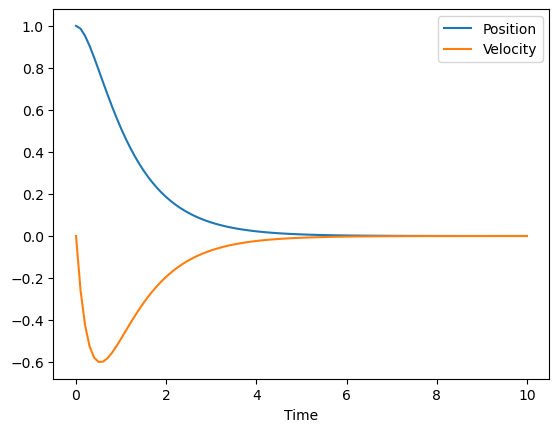

PyObject <matplotlib.legend.Legend object at 0x7f5f4c7f8070>

In [13]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
plot(thist,xhist[1,:], label="Position")
plot(thist,xhist[2,:], label="Velocity")
xlabel("Time")
legend()

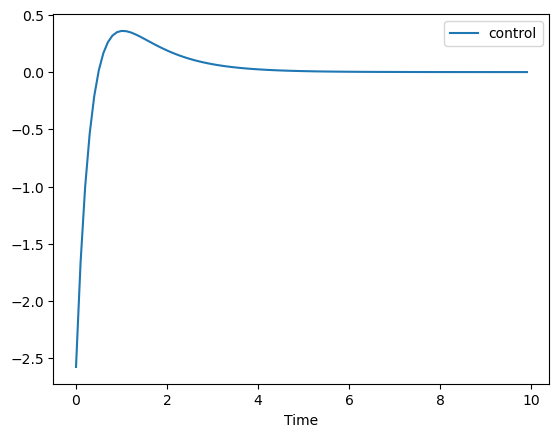

PyObject <matplotlib.legend.Legend object at 0x7f5f607d6d70>

In [14]:
plot(thist[1:end-1], uhist, label="control")
xlabel("Time")
legend()